Anne Urai, CSHL, 2019

code for https://www.abstractsonline.com/pp8/#!/7883/presentation/46202

see also Reinagel et al. Frontiers for effects of CA water in rats.

In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306


# STUDY 1. effects of CA on water intake and weight
data collected by Ines Laranjeira and Fanny Cazettes, CCU

In [2]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'subject_project = "collab_citricacid"' & 'lab_name="mainenlab"'

########### WEIGHINGS ########### 

weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2018-10-24"'
baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date = "2018-09-24"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
bb = subj * avg_baseline_weight_date

weight_df = pd.DataFrame(b.fetch(as_dict=True))
#weight_df.tail(n=10)

baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
#baseline_df.tail(n=10)

In [3]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

baseline_date = datetime.toordinal(datetime(2018, 9, 24))
change_date = datetime.toordinal(datetime(2018, 10, 5)) 

# Citric acid 2% was given on the 4th of Oct but on that day there was a 5-min 
# free water session, so I the 5th of Oct is used, as it is more accurate to show the effect of the change in concentration

normalized_df = weight_df.copy()
subject_count = 0
for s in baseline_df['subject_uuid']:
    subject_count += 1
    entry = normalized_df['subject_uuid'] == s # outputs list of booleans - True for all entries of mouse s 
    
    weight_count = 0
    for d in entry:
        weight_count += 1
        if d == True:
            normalized_df['avg_weight'][weight_count-1] = normalized_df['avg_weight'][weight_count-1] / baseline_df['avg_weight'][subject_count-1]
            normalized_df['session_date'][weight_count-1]  = datetime.toordinal(normalized_df['session_date'][weight_count-1]) - baseline_date
            

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

# now, we want to map these onto the subject names
CTL = 'Free water'
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'

condition_map = {'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL, 
'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD}

normalized_df['condition'] = normalized_df.subject_nickname.map(condition_map)
#normalized_df.tail(n=10)
#weight_df['condition'] = weight_df.subject_nickname.map(condition_map)

/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


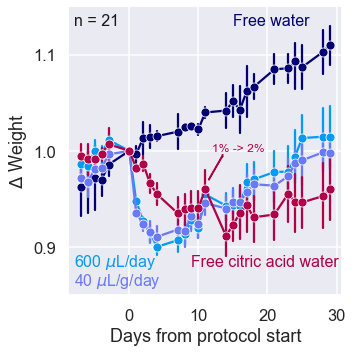

In [4]:
########### PLOTS ########### 
palette = sns.xkcd_palette(['deep blue', 'azure', 'cornflower', 'raspberry'])
hue_order = ['Free water', 'Fixed amount', 'Weight-based amount', 'Citric Acid']

f, ax = plt.subplots(1,1, figsize=(5, 5))
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', 
             ci=68, hue="condition", marker='o', data=normalized_df, ax=ax, legend=False, 
            palette=palette, hue_order=hue_order)
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("$\Delta$ Weight")         
ax.set(ylim=[0.85, 1.15], yticks=[0.9, 1, 1.1])
ax.text(15, 1.13,'Free water', {'color':palette[0], 'fontsize':16})
ax.text(-8, 0.88,'600 $\mu$L/day', {'color':palette[1], 'fontsize':16})
ax.text(-8, 0.86,'40 $\mu$L/g/day', {'color':palette[2], 'fontsize':16})
ax.text(9, 0.88,'Free citric acid water', {'color':palette[3], 'fontsize':16})
ax.text(12, 1,'1% -> 2%', {'color':palette[3], 'fontsize':12})
ax.text(-8, 1.13, 'n = 21', {'color':'k', 'fontsize':16})
plt.arrow(11.5, 0.97, 2, 0.025, color=palette[3])
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study1_weight_over_time.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1_weight_over_time.png"), dpi=600)


In [5]:
########### WATER ADMINISTRATIONS ########### 

water_with_date = (action.WaterAdministration & subj).proj('watertype_name', 'water_administered', 'adlib', # it can restrict on the subj here but it will anyway do later
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date) & 'session_date < "2018-10-24"'& 'session_date > "2018-10-05"'
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
b = subj * total_water_date # including water will exclude mice with ad lib water

df = pd.DataFrame(b.fetch(as_dict=True))

########### CONDITIONS ########### 

# CTL = free water regime (control)
# CA = ad libitum citric acid water
# FA = fixed amount of water per day (600 uL per weekday and 1 mL per weekend)
# CA = calculated amount (40 uL/g/day)

CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

df['condition'] = df.subject_nickname.map(condition_map)

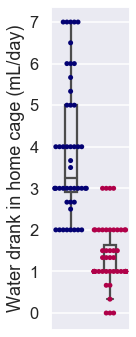

In [6]:
########### PLOTS ########### 

f, ax = plt.subplots(1,1, figsize=(2, 5))
sns.swarmplot(x="condition", y="total_water", order=['Free water', 'Citric Acid'],  
              data=df, ax=ax, palette = sns.xkcd_palette(['deep blue', 'raspberry']))
sns.boxplot(x="condition", y="total_water", order=[ 'Free water', 'Citric Acid'], data=df, fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax)
ax.set(ylabel='Water drank in home cage (mL/day)', xlabel='')
ax.set_xticklabels(['', ''])
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study1_waterconsumption_homecage.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1_waterconsumption_homecage.png"), dpi=600)

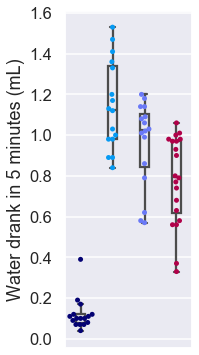

In [8]:
########### WATER ########### 
water= pd.read_csv('thirst.csv') # first date is exclude (habituation)

# MAP MICE ONTO DIFFERENT CONDITIONS
CA = 'Citric Acid'
WD = 'Weight-based amount'
FA = 'Fixed amount'
CTL = 'Free water'

condition_map = {'6867': CA, '6869':CA, 'ZM_209':CA, '6872':CA, 'ZM_342':CA,
'ZM_202':FA, 'ZM_337':FA, 'ZM_206':FA, 'ZM_208':FA, 
'ZM_203':WD, 'ZM_210':WD, 'ZM_338':WD, '6870':WD,
'ZM_205':CTL, 'ZM_335':CTL, '6873':CTL, 'ZM_200':CTL}

water['condition'] = water.subject.map(condition_map)

########### PLOTTING ########### 
f, ax = plt.subplots(1,1, figsize=(3, 5))
sns.swarmplot(x="condition", y="water_amount", order=hue_order,  
              data=water, ax=ax, palette =palette)
sns.boxplot(x="condition", y="water_amount", order=hue_order, 
            data=water, fliersize=0, boxprops={'facecolor':'None'}, width=.3, ax=ax)
ax.set(ylabel='Water drank in 5 minutes (mL)', xlabel='')
ax.set_xticklabels(['', ''])
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study1_waterconsumption_5minutes.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1_waterconsumption_5minutes.png"), dpi=600)

# STUDY 2. effects of CA on task performance
data collected by Valeria Aguillon and Anne Urai, CSHL

In [33]:
# FIND THE DATA WE NEED
subj = (subject.Subject() - subject.Death & 'subject_birth_date < "2018-09-01"').proj('subject_nickname', 'sex') * \
    (subject.SubjectLab() & 'lab_name="churchlandlab"').proj()
print(subj)

# get date for each weighing
weight_with_date = action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')

# NOW DO THE SAME FOR WATER
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
# total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
#                                    watertype="CONCAT_WS('; ', watertype_name)")
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')
# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)') & 'session_date > "2019-03-17"') \
    * behavioral_analyses.PsychResults()
b = subj * session_with_date * avg_weight_date * total_water_date
df = pd.DataFrame(b.fetch(as_dict=True))
df.tail(n=10)

# ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['weekday']      = df['session_date'].dt.weekday

# THEN GIVE EVERY WEEK A CONDITION NAME!
#
# let's define 5 conditions
# O = one mL water in weekend, sucrose water in task
# C = citric acid water in weekend, sucrose water in task
# CC = citric acid water in weekend + week, sucrose water in task
# W = regular water in weekend, sucrose water in task
# WW = regular water in weekend + week, sucrose water in task
#
# now, we want to map these onto the week numbers
condition_map = {10:'CC', 11:'C', 12:'C', 13:'C', 14:'C', 15:'C', 16:'C', 
                 17:'CC', 18:'C', 19:'WW', 20:'O', 21:'C', 22:'C', 23:'C', 24:'C', 25:'WW',
                27:'CC', 28:'WW', 29:'O', 30:'CC', 31:'W', 32:'O', 33:'W', 34:'W', 36:'H', 36:'H'}

df['condition'] = df.week_number.map(condition_map)

# SHOW THIS, AND CHECK THAT IT'S CORRECT!
# sanitycheck = df.groupby(['week_number', 'condition', 'session_date', 'weekday_name'])['watertype'].unique()
# sanitycheck.to_csv(os.path.join(figpath, "check_water_conditions.csv"))

# redo the color mapping
condition_order = ["WW", "W", "O", "C", "H", "CC"]
palette = sns.xkcd_palette(['deep blue', 'electric blue', 'azure', 'purpley pink', 'dark lilac', 'raspberry'])


*subject_uuid  subject_nickna sex    
+------------+ +------------+ +-----+
1208c089-8b8e- IBL_13         M      
3f854f88-7879- IBL_11         M      
52a800fc-cbbc- IBL_1          M      
55381f61-4e47- IBL_46         M      
7c751b49-55a6- IBL_10         M      
 (Total: 5)



/anaconda3/envs/djenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [38]:
# MAKE NICE-LOOKING DATE AXES
import matplotlib.dates as mdates
def fix_date_axis(ax):
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for item in ax.get_xticklabels():
        item.set_rotation(-40)

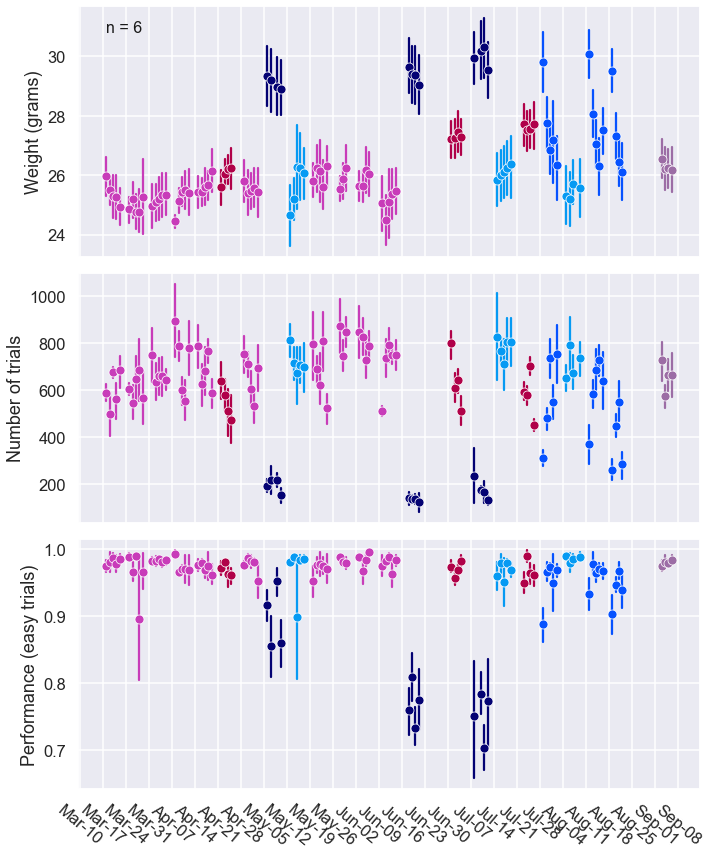

In [49]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(10, 12))
sns.lineplot(x="session_date", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=0, data=df, ax=ax[0], legend=False, hue_order=condition_order, palette=palette)
ax[0].set(ylabel="Weight (grams)", xlabel="Days")
ax[0].text(df.session_date.min(), 30.8, 'n = 6', {'color':'k', 'fontsize':16})

sns.lineplot(x="session_date", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[1], legend=False, hue_order=condition_order, palette=palette)
ax[1].set(ylabel="Number of trials", xlabel="")
sns.lineplot(x="session_date", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=0, data=df, ax=ax[2], legend=False, hue_order=condition_order, palette=palette)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")

# set grid to show Mondays
fix_date_axis(ax[2])
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study2_data_overtime.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study2_data_overtime.png"), dpi=300)

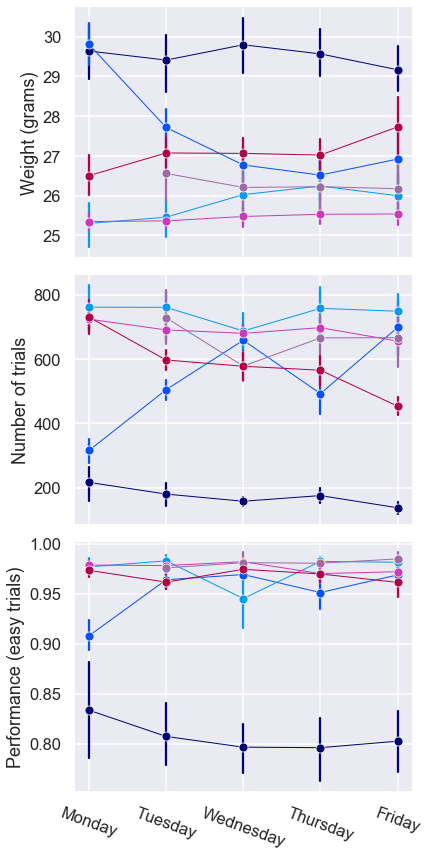

In [50]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))
sns.lineplot(x="weekday", y="avg_weight", err_style='bars', ci=68, hue="condition", marker='o', 
             linewidth=1, data=df, ax=ax[0], legend=False, hue_order=condition_order, palette=palette)
ax[0].set(ylabel="Weight (grams)")
sns.lineplot(x="weekday", y="n_trials", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[1], legend=False, hue_order=condition_order, palette=palette)
ax[1].set(ylabel="Number of trials")
sns.lineplot(x="weekday", y="performance_easy", err_style='bars', ci=68, hue="condition", marker='o',  
             linewidth=1, data=df, ax=ax[2], legend=False, hue_order=condition_order, palette=palette)
ax[2].set(ylabel="Performance (easy trials)", xticks=[0,1,2,3,4], 
          xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], xlabel="")

for item in ax[2].get_xticklabels():
    item.set_rotation(-20)
    
# set grid to show Mondays
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study2_withinweek.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study2_withinweek.png"), dpi=300)

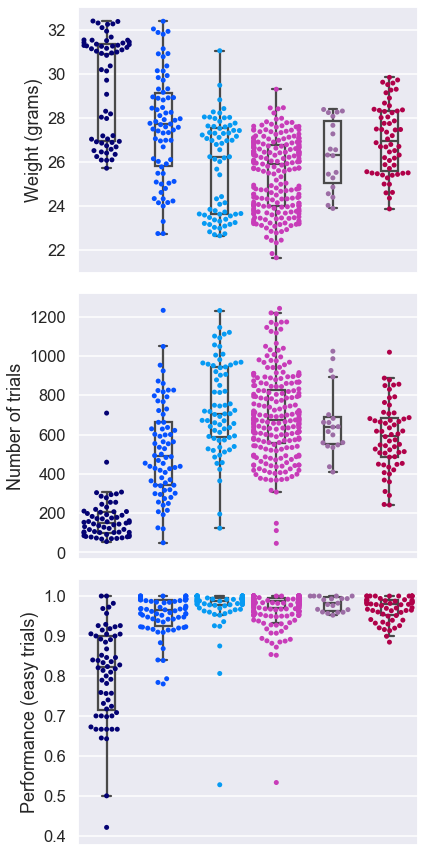

In [51]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(3,1, sharex=True, figsize=(6, 12))

sns.swarmplot(x="condition", y="avg_weight", order=condition_order,  hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[0])
sns.boxplot(x="condition", y="avg_weight", order=condition_order,data=df, fliersize=0, ax=ax[0], boxprops={'facecolor':'None'}, width=.3)
ax[0].set(ylabel="Weight (grams)", xlabel="")
ax[0].get_legend().remove()

sns.swarmplot(x="condition", y="n_trials", order=condition_order, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[1])
sns.boxplot(x="condition", y="n_trials", order=condition_order, data=df, fliersize=0, ax=ax[1], boxprops={'facecolor':'None'}, width=.3)
ax[1].set(ylabel="Number of trials", xlabel="")
ax[1].get_legend().remove()

sns.swarmplot(x="condition", y="performance_easy", order=condition_order, hue_order=condition_order, palette=palette, hue="condition", data=df, ax=ax[2])
sns.boxplot(x="condition", y="performance_easy", order=condition_order, data=df, fliersize=0, ax=ax[2], boxprops={'facecolor':'None'}, width=.3)
ax[2].set(ylabel="Performance (easy trials)", xlabel="")
ax[2].get_legend().remove()

ax[2].set_xticklabels('')

# set grid to show Mondays
f.tight_layout()
f.savefig(os.path.join(figpath, "citricacid_study2_stats.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study2_stats.png"), dpi=300)
